# How easy is it to train Contextualized Regression Models?
Contextual model allows to identify heterogeneous effects which change between different contexts. The `contextualized` package provides easy access to these heterogeneous models through the `contextualized.easy` module interfaces. This notebook shows a simple example of using `contextualized.easy` regression. 

Note: These `contextualized.easy` interfaces don't try to use best PyTorch practices (prioritizing easy use over computational efficiency), so it's recommended to use `contextualized` models for any heavy lifting (see this [demo](https://github.com/cnellington/Contextualized/blob/main/demos/main_demo.ipynb)).

### 1. Generate Simulation Data
In this simulated regression, we'll study the simple varying-coefficients case where $Y =X\beta(C) + \epsilon$, with $\beta(C) \sim \text{N}(C\phi, \text{I})$.

In [1]:
import numpy as np
n_samples = 100
n_outcomes = 3
n_context = 1
n_observed = 1
C = np.random.uniform(-1, 1, size=(n_samples, n_context))
X = np.random.uniform(0, 0.5, size=(n_samples, n_observed))
phi = np.random.uniform(-1, 1, size=(n_context, n_observed, n_outcomes))
beta = np.tensordot(C, phi, axes=1) + np.random.normal(0, 0.1, size=(n_samples, n_observed, n_outcomes))
Y = np.array([np.tensordot(X[i], beta[i], axes=1) for i in range(n_samples)])

### 2. Build and fit model
Uses an sklearn-type wrapper interface.

In [2]:
from contextualized.easy import ContextualizedRegressor
model = ContextualizedRegressor()
model.fit(C, X, Y, max_epochs=10, learning_rate=1e-3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params
---------------------------------------------
0 | metamodel | NaiveMetamodel | 206   
---------------------------------------------
206       Trainable params
0         Non-trainable params
206       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Common constructor keywords include:

    - n_bootstraps: The integer number of bootstrap runs to fit.
    - encoder_type: 'mlp' or 'ngam', which type of model to make as context encoder.
    - loss_fn: A function to calculate loss (see 'contextualized.regression.LOSSES')
    - alpha: non-negative float, regularization strength.
    - mu_ratio: float in range (0.0, 1.0), governs how much the regularization applies to context-specific parameters or context-specific offsets.
    - l1_ratio: float in range (0.0, 1.0), governs how much the regularization penalizes l1 vs l2 parameter norms.

Common fitting keywords include:

    - max_epochs: positive number, the maximum number of epochs to fit. Early stopping is turned on by default.
    - learning_rate: positive float, default is 1e-3.
    - val_split: float in range (0.0, 1.0), how much of the data to use for validation (early stopping).

### 3. Inspect the model predictions.

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 80it [00:00, ?it/s]

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


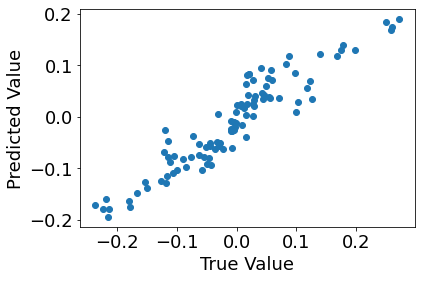

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y[:, 0], model.predict(C, X)[:, 0])
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

### 4. Check what the individual bootstrap models learned.

Predicting: 80it [00:00, ?it/s]

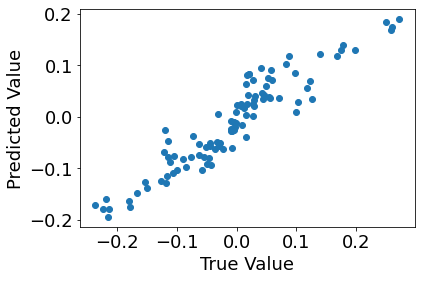

In [4]:
model_preds = model.predict(C, X, individual_preds=True)
for pred in model_preds:
    plt.scatter(Y[:, 0], pred[:, 0])
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

### 5. Check what parameters the models learned.

Predicting: 80it [00:00, ?it/s]

Predicting: 80it [00:00, ?it/s]

(1, 100, 3, 1)


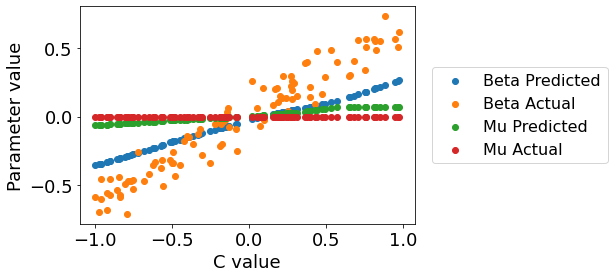

In [5]:
beta_preds, mu_preds = model.predict_params(C, individual_preds=False)
plt.scatter(C, beta_preds[:, 0], label='Beta Predicted')
plt.scatter(C, beta[:, :, 0], label='Beta Actual')
plt.scatter(C, mu_preds[:, 0], label='Mu Predicted')
plt.scatter(C, np.zeros_like(C), label='Mu Actual')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), fontsize=16)
plt.xlabel("C value")
plt.ylabel("Parameter value")
plt.show()